# Figure - CoMIGHT varying n-dims for power

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import warnings

warnings.filterwarnings("ignore")

In [3]:
import math
import string
from collections import defaultdict
from itertools import product
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from joblib import Parallel, delayed
from matplotlib.ticker import NullFormatter, ScalarFormatter, StrMethodFormatter
from sklearn.metrics import roc_auc_score

seed = 12345
rng = np.random.default_rng(seed)

In [4]:
root_dir = Path("/Volumes/Extreme Pro/cancer/output/final_resultsv2/")

sim_names = ["mean_shiftv4", "multi_modalv2", "multi_equal"]

n_dims_1 = 512 - 6
n_samples = 1024
n_repeats = 100

# Plot Figure S6 (Power)

In [50]:
sim_names = ["mean_shiftv4", "multi_modalv2", "multi_equal"]

In [51]:
n_dims_1 = 512 - 6

In [52]:
# varying n_samples
cdcorr_df = pd.DataFrame()

metric = "cdcorr_pvalue"
model = "cdcorr"
for sim_name in sim_names:
    fname = (
        root_dir
        / f"results_vs_nsamples_{sim_name}_{model}_{metric}_{n_dims_1}_{n_repeats}.csv"
    )
    df = pd.read_csv(fname, index_col=None)

    # convert pvalue to binary
    df["pvalue"] = df["metric_value"] <= 0.05

    print(
        df["pvalue"].sum(),
        df["pvalue"].count(),
        df["pvalue"].sum() / df["pvalue"].count(),
    )
    # compute power per sample size
    # df = df.groupby("n_samples")["pvalue"].agg(["mean", "std"])
    # df.columns = df.columns.map({"mean": "pvalue", "std": "pval_std"})
    result_df = pd.DataFrame()
    print((1 + df["pvalue"].sum()) / (1 + df["pvalue"].count()))
    result_df["n_samples"] = df["n_samples"].unique()
    result_df["pvalue"] = (1 + df["pvalue"].sum()) / (1 + df["pvalue"].count())
    result_df["model"] = "CDCorr"
    result_df["sim_type"] = sim_name
    # result_df.reset_index(inplace=True)
    cdcorr_df = pd.concat((cdcorr_df, result_df), axis=0)

display(cdcorr_df)

34 200 0.17
0.17412935323383086
26 200 0.13
0.13432835820895522
30 200 0.15
0.15422885572139303


,n_samples,pvalue,model,sim_type
0,256,0.174129,CDCorr,mean_shiftv4
1,512,0.174129,CDCorr,mean_shiftv4
0,256,0.134328,CDCorr,multi_modalv2
1,512,0.134328,CDCorr,multi_modalv2
0,256,0.154229,CDCorr,multi_equal
1,512,0.154229,CDCorr,multi_equal


In [53]:
metric = "cmi"
comight_df = pd.DataFrame()
for sim_name in sim_names:
    model = "comight"
    fname = (
        root_dir
        / f"results_vs_nsamples_{sim_name}_comight-power_{n_dims_1}_{n_repeats}.csv"
    )
    result_df = pd.read_csv(fname, index_col=None)

    model = "comight-perm"
    fname = (
        root_dir
        / f"results_vs_nsamples_{sim_name}_comightperm-power_{n_dims_1}_{n_repeats}.csv"
    )
    perm_result_df = pd.read_csv(fname, index_col=None)

    results = defaultdict(list)
    for sample_size in perm_result_df["n_samples"].unique():
        threshold = np.percentile(perm_result_df[metric], 95)

        print(sim_name, sample_size, threshold)
        # Grouping the first dataframe by 'n_samples' and counting the number of rows for each 'n_samples'
        print(perm_result_df.shape)
        # print(perm_result_df[perm_result_df['n_samples'] == sample_size])
        count = perm_result_df[perm_result_df["n_samples"] == sample_size].shape[0]

        # Filtering the rows in df1 where 'metric_value' is greater than or equal to the corresponding value in df2
        # perm_result_df = perm_result_df.iloc[0:1]
        filtered_df1 = result_df[
            (result_df[metric] >= threshold) & (result_df["n_samples"] == sample_size)
        ]

        # Normalizing by dividing the filtered counts by the total counts
        normalized_count = (1 + len(filtered_df1)) / (1 + count)
        results["n_samples"].append(sample_size)
        results["pvalue"].append(normalized_count)

    pvalue_df = pd.DataFrame(results)
    pvalue_df["model"] = "CoMIGHT"
    pvalue_df["sim_type"] = sim_name
    # pvalue_df.reset_index(inplace=True)

    comight_df = pd.concat((comight_df, pvalue_df), axis=0)
    # display(comight_df)
# df = df.groupby("n_samples")["pvalue"].agg(["mean", "std"])
# df.columns = df.columns.map({"mean": "pvalue", "std": "pval_std"})
# df["model"] = "CoMIGHT"

comight_df.reset_index(drop=True, inplace=True)
#
# comight_df.fillna(0, inplace=True)

mean_shiftv4 256 0.00029008180463432003
(300, 6)
mean_shiftv4 512 0.00029008180463432003
(300, 6)
mean_shiftv4 1024 0.00029008180463432003
(300, 6)
multi_modalv2 256 0.00028568942679145005
(300, 6)
multi_modalv2 512 0.00028568942679145005
(300, 6)
multi_modalv2 1024 0.00028568942679145005
(300, 6)
multi_equal 256 0.000278445356709465
(300, 6)
multi_equal 512 0.000278445356709465
(300, 6)
multi_equal 1024 0.000278445356709465
(300, 6)


In [54]:
sample_df = pd.concat((cdcorr_df, comight_df), axis=0)

In [63]:
comight_df = pd.DataFrame()
n_samples = 512
metric = "cmi"
for sim_name in sim_names:
    model = "comight"
    fname = (
        root_dir
        / f"results_vs_ndims_{sim_name}_comight-power_{n_samples}_{n_repeats}.csv"
    )
    result_df = pd.read_csv(fname, index_col=None)
    # result_df = result_df[result_df["n_dims_1"] < 1000]

    model = "comight-perm"
    fname = (
        root_dir
        / f"results_vs_ndims_{sim_name}_comightperm-power_{n_samples}_{n_repeats}.csv"
    )
    perm_result_df = pd.read_csv(fname, index_col=None)
    # perm_result_df = perm_result_df[perm_result_df["n_dims_1"] < 1000]

    results = defaultdict(list)
    for n_dims_1 in perm_result_df["n_dims_1"].unique():
        threshold = np.percentile(perm_result_df[metric], 95)

        print(sim_name, n_dims_1, threshold)
        # Grouping the first dataframe by 'n_samples' and counting the number of rows for each 'n_samples'
        print(perm_result_df.shape)
        # print(perm_result_df[perm_result_df['n_samples'] == sample_size])
        count = perm_result_df[perm_result_df["n_dims_1"] == n_dims_1].shape[0]

        # Filtering the rows in df1 where 'metric_value' is greater than or equal to the corresponding value in df2
        # perm_result_df = perm_result_df.iloc[0:1]
        filtered_df1 = result_df[
            (result_df[metric] >= threshold) & (result_df["n_dims_1"] == n_dims_1)
        ]

        # Normalizing by dividing the filtered counts by the total counts
        normalized_count = (1 + len(filtered_df1)) / (1 + count)
        results["n_dims_1"].append(n_dims_1)
        results["pvalue"].append(normalized_count)

    pvalue_df = pd.DataFrame(results)
    pvalue_df["model"] = "CoMIGHT"
    pvalue_df["sim_type"] = sim_name
    pvalue_df.reset_index(inplace=True)

    comight_df = pd.concat((comight_df, pvalue_df), axis=0)
    # display(comight_df)
# df = df.groupby("n_samples")["pvalue"].agg(["mean", "std"])
# df.columns = df.columns.map({"mean": "pvalue", "std": "pval_std"})
# df["model"] = "CoMIGHT"


comight_df.reset_index(drop=True, inplace=True)

mean_shiftv4 2 0.0008113502131165589
(800, 6)
mean_shiftv4 10 0.0008113502131165589
(800, 6)
mean_shiftv4 26 0.0008113502131165589
(800, 6)
mean_shiftv4 58 0.0008113502131165589
(800, 6)
mean_shiftv4 122 0.0008113502131165589
(800, 6)
mean_shiftv4 250 0.0008113502131165589
(800, 6)
mean_shiftv4 506 0.0008113502131165589
(800, 6)
mean_shiftv4 1018 0.0008113502131165589
(800, 6)
multi_modalv2 2 0.0010152793301617345
(800, 6)
multi_modalv2 10 0.0010152793301617345
(800, 6)
multi_modalv2 26 0.0010152793301617345
(800, 6)
multi_modalv2 58 0.0010152793301617345
(800, 6)
multi_modalv2 122 0.0010152793301617345
(800, 6)
multi_modalv2 250 0.0010152793301617345
(800, 6)
multi_modalv2 506 0.0010152793301617345
(800, 6)
multi_modalv2 1018 0.0010152793301617345
(800, 6)
multi_equal 2 0.00071927099076165
(800, 6)
multi_equal 10 0.00071927099076165
(800, 6)
multi_equal 26 0.00071927099076165
(800, 6)
multi_equal 58 0.00071927099076165
(800, 6)
multi_equal 122 0.00071927099076165
(800, 6)
multi_equal 

In [66]:
# varying n_samples
cdcorr_df = pd.DataFrame()
metric = "cdcorr_pvalue"
model = "cdcorr"
for sim_name in sim_names:
    fname = (
        root_dir / f"results_vs_ndims_{sim_name}_{model}_{metric}_{506}_{n_repeats}.csv"
    )
    df = pd.read_csv(fname, index_col=None)

    # convert pvalue to binary
    df["pvalue"] = df["metric_value"] <= 0.05

    print(
        df["pvalue"].sum(),
        df["pvalue"].count(),
        df["pvalue"].sum() / df["pvalue"].count(),
    )
    # compute power per sample size
    # df = df.groupby("n_samples")["pvalue"].agg(["mean", "std"])
    # df.columns = df.columns.map({"mean": "pvalue", "std": "pval_std"})
    result_df = pd.DataFrame()
    print((1 + df["pvalue"].sum()) / (1 + df["pvalue"].count()))
    result_df["n_dims_1"] = df["n_dims_1"].unique()
    result_df["pvalue"] = (1 + df["pvalue"].sum()) / (1 + df["pvalue"].count())
    result_df["model"] = "CDCorr"
    result_df["sim_type"] = sim_name
    # result_df.reset_index(inplace=True)
    cdcorr_df = pd.concat((cdcorr_df, result_df), axis=0)

display(cdcorr_df)

124 800 0.155
0.1560549313358302
119 800 0.14875
0.149812734082397
102 800 0.1275
0.1285892634207241


,n_dims_1,pvalue,model,sim_type
0,2,0.156055,CDCorr,mean_shiftv4
1,10,0.156055,CDCorr,mean_shiftv4
2,26,0.156055,CDCorr,mean_shiftv4
3,58,0.156055,CDCorr,mean_shiftv4
4,122,0.156055,CDCorr,mean_shiftv4
5,250,0.156055,CDCorr,mean_shiftv4
6,506,0.156055,CDCorr,mean_shiftv4
7,1018,0.156055,CDCorr,mean_shiftv4
0,2,0.149813,CDCorr,multi_modalv2
1,10,0.149813,CDCorr,multi_modalv2


In [67]:
dim_df = pd.concat((cdcorr_df, comight_df), axis=0)

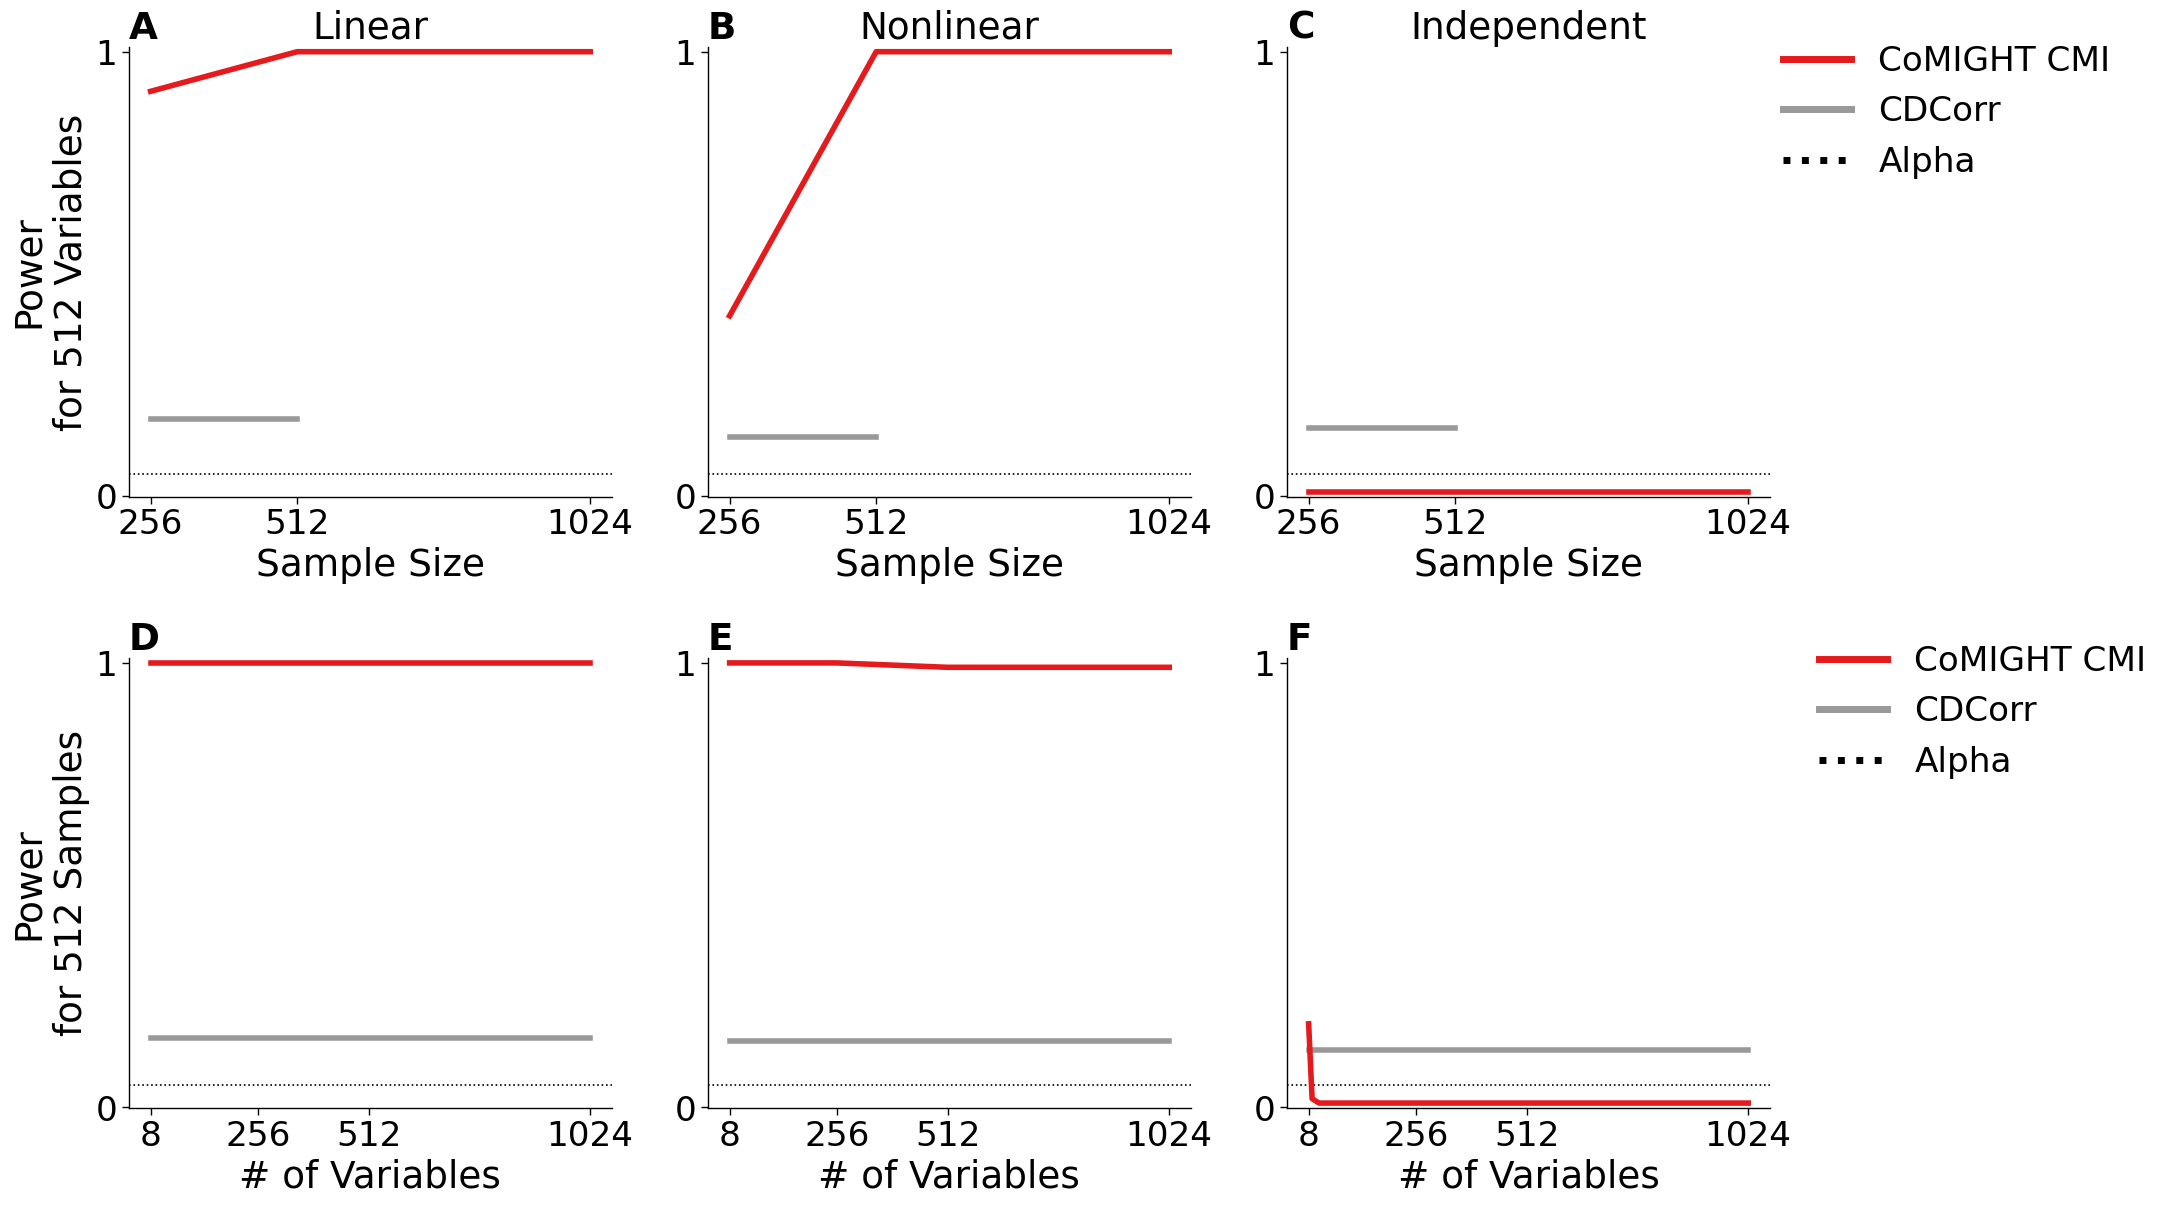

In [69]:
sns.set_context("paper", font_scale=2.8)
metric = "CMI"
# in order of rows
titles = ["Linear", "Nonlinear", "Independent"]

# plot the order of the dataframes per row
dfs = [sample_df, dim_df]
xnames = ["n_samples", "n_dims_1"]

fig, axs = plt.subplots(2, 3, figsize=(18, 12))
for irow in range(2):
    row_df = dfs[irow]
    xname = xnames[irow]

    for idx, sim_name in enumerate(sim_names):
        plot_df = row_df[row_df["sim_type"] == sim_name]

        plot_df["model"] = plot_df["model"].apply(lambda x: str(x).lower())
        plot_df["model"] = plot_df["model"].str.replace("cdcorr", "CDCorr", regex=False)
        plot_df["model"] = plot_df["model"].str.replace(
            "comight", f"CoMIGHT {metric.upper()}", regex=False
        )

        palette = {f"CoMIGHT {metric.upper()}": "#e41a1c", "CDCorr": "#999999"}

        # begin plotting
        ax = axs[irow][idx]

        if "n_dims_1" in plot_df.columns:
            plot_df["n_dims_1"] += 6
            ax.set_xticks([8, 256, 512, 1024])
        else:
            ax.set_xticks([256, 512, 1024])
        ax.axhline([0.05], ls=":", label="Alpha", color="#000000")
        ax = sns.lineplot(
            data=plot_df,
            x=xname,
            y="pvalue",
            hue="model",
            ax=ax,
            palette=palette,
            linewidth=4,
            errorbar="ci",
        )

        # set y lim and ticks
        ax.set_ylim([-0.001, 1.01])
        ax.set_yticks([0, 1.0])

        # if sim_name == "multi_equal":
        # ax.set(ylim=[-0.01, 0.1])

        sns.despine(right=True, ax=ax)
        ax.get_legend().set_visible(False)
        ax.set_ylabel(None)
        ax.set_xlabel(None)
        if irow == 0:
            ax.set_title(titles[idx])

        ax.xaxis.set_major_formatter(ScalarFormatter())
        ax.xaxis.set_minor_formatter(NullFormatter())
        ax.set_title(
            string.ascii_uppercase[irow * len(sim_names) + idx],
            loc="left",
            weight="bold",
        )

    # sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

for icol in range(len(sim_names)):
    axs[1][icol].set_xlabel("# of Variables")
    axs[0][icol].set_xlabel("Sample Size")

axs[0][0].set_ylabel("Power\nfor 512 Variables")
axs[1][0].set_ylabel("Power\nfor 512 Samples")
fig.tight_layout(pad=0.2, w_pad=1.0, h_pad=1.0)
legend_locs = [(1.08, 0.99), (1.1, 0.49)]
for i in range(2):
    leg = axs[i][0].legend(
        bbox_to_anchor=legend_locs[i],
        bbox_transform=plt.gcf().transFigure,
        ncol=1,
        loc="upper center",
        reverse=True,
    )
    leg.get_frame().set_linewidth(0.0)
    for legobj in leg.legend_handles:
        legobj.set_linewidth(5.0)

fig_name = "figure-s6"
plt.savefig(f"{FIG_PATH}/{fig_name}.svg", transparent=True, bbox_inches="tight")
plt.show()